## Import library and dataset

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from functools import reduce
%matplotlib inline
import nltk
import spacy 
import unicodedata
import re

In [2]:
aot_reviews = pd.read_csv('datasets/Attack-on-Titan.csv', index_col=0)

## Head of the dataset

In [3]:
aot_reviews.head(5)

,star,title,date,number_of_votes,number_of_votes_helpful,content
0,10.0,Masterpiece. I've never witnessed this level o...,2019-06-19,394.0,379.0,The moment you watch this audiovisual masterpi...
1,10.0,Nearly perfect,2019-12-17,176.0,171.0,"Before I started watching this show, I couldn'..."
2,10.0,"Season 4, what can we expect?",2020-01-04,68.0,67.0,"A lot of people have this question, can season..."
3,10.0,Next 12 episodes of season 3 will be AMAZING,2018-10-17,420.0,392.0,The best part of the series is coming in april...
4,10.0,Shinzou wo sasageyo! Devote your heart!,2019-06-08,100.0,96.0,I'm not an expert of anime. I haven't even rea...


In [4]:
aot_reviews.groupby('star').agg({
    'title': 'count'
}).reset_index().rename(columns={'title': 'n'})

,star,n
0,1.0,15
1,2.0,4
2,3.0,8
3,4.0,13
4,5.0,12
5,6.0,14
6,7.0,19
7,8.0,24
8,9.0,58
9,10.0,472


## Take an example text

In [5]:
txt = aot_reviews.iloc[5]['content']

## Tokenize the text using nltk
### Sentence tokenization

In [6]:
st = nltk.sent_tokenize
st_example = st(text=txt)

In [7]:
len(st_example)

4

In [8]:
st_example

["Trust me, you'll be having almost panic-attack-like excitement after every episode of this programme.",
 "You can't ever tell where the story is going next, and the production is riduculous.",
 'The cinematics are incredible, the character stories mesh together in perfect harmony and better than anything else - it wants you leaving more and more every single week.',
 'Definitely recommend this to not just anyone who loves Anime, but anyone who loves TV!']

### Word tokenization

In [9]:
wt = nltk.word_tokenize 

In [10]:
wt(txt)

['Trust',
 'me',
 ',',
 'you',
 "'ll",
 'be',
 'having',
 'almost',
 'panic-attack-like',
 'excitement',
 'after',
 'every',
 'episode',
 'of',
 'this',
 'programme',
 '.',
 'You',
 'ca',
 "n't",
 'ever',
 'tell',
 'where',
 'the',
 'story',
 'is',
 'going',
 'next',
 ',',
 'and',
 'the',
 'production',
 'is',
 'riduculous',
 '.',
 'The',
 'cinematics',
 'are',
 'incredible',
 ',',
 'the',
 'character',
 'stories',
 'mesh',
 'together',
 'in',
 'perfect',
 'harmony',
 'and',
 'better',
 'than',
 'anything',
 'else',
 '-',
 'it',
 'wants',
 'you',
 'leaving',
 'more',
 'and',
 'more',
 'every',
 'single',
 'week',
 '.',
 'Definitely',
 'recommend',
 'this',
 'to',
 'not',
 'just',
 'anyone',
 'who',
 'loves',
 'Anime',
 ',',
 'but',
 'anyone',
 'who',
 'loves',
 'TV',
 '!']

In [11]:
"""
import spacy
nlp = spacy.load('en', parse = True, tag=True, entity=True)
text_spacy = nlp(txt)
list(text_spacy.sents)
[[word.text for word in sent] for sent in text_spacy.sents]
"""

"\nimport spacy\nnlp = spacy.load('en', parse = True, tag=True, entity=True)\ntext_spacy = nlp(txt)\nlist(text_spacy.sents)\n[[word.text for word in sent] for sent in text_spacy.sents]\n"

## Try feature engineering methods
Methods are going to be applied to reviews of different stars

In [12]:
from nltk import WordPunctTokenizer

stopwords = nltk.corpus.stopwords.words('english')

def normalize_review_sent(review): #(By the textbook)
        # lowercase and remove special characters\whitespace
        review = re.sub(r'[^a-zA-Z\s]', '', review, re.I|re.A)
        review = review.lower()
        review = review.strip()
        
        # tokenize document
        wpt = WordPunctTokenizer()
        tokens = wpt.tokenize(review)
        
        # filter stopwords out of document
        filtered_tokens = [token for token in tokens if token not in stopwords] # re-create document from filtered tokens
        review = ' '.join(filtered_tokens)
        return review

class Review_Corpus_Cleaned:
    def __init__(self, df):
        self.group_by_df = df.groupby(by='star')
        
        
    #Private functions
    __normalize_review_sent_vectorize = np.vectorize(normalize_review_sent)
    
    def __sent_token(self, review):
        st = nltk.sent_tokenize 
        st_review = st(review)
        norm_st = self.__normalize_review_sent_vectorize(st_review)
        return norm_st
        
    def __word_token(self, review):
        review = re.sub(r'[^a-zA-Z\s]', '', review, re.I|re.A)
        review = review.lower()
        review = review.strip()
        review = normalize_review_sent(review)
        wt = nltk.word_tokenize 
        wt_review = wt(review)
        return wt_review
    
    def __review_sent_tokenize(self, review_ser):
        return list(map(lambda x: self.__sent_token(x), review_ser))
        
    def __review_word_tokenize(self, review_ser):
        return list(map(lambda x: self.__word_token(x), review_ser))
    
    def __generate_token_df(self, f, stars):
        if (not isinstance(stars, (list, tuple))) and stars is not None:
            stars = [stars]

        ret_df = pd.DataFrame(self.group_by_df.agg({
                    'content': f
                    })).reset_index()
        
        if stars is None:
            return ret_df
        else:
            ret_rows = list(np.array(stars).astype('int') - 1)
            if len(ret_rows) == 1:
                return ret_df.iloc[ret_rows, 1].iloc[0]
            else:
                return ret_df.iloc[ret_rows, :]
        
    #Public functions
    def sent_corpus(self, stars=None):
        return self.__generate_token_df(self.__review_sent_tokenize, stars)
        
    def word_corpus(self, stars=None):
        return self.__generate_token_df(self.__review_word_tokenize, stars)

In [13]:
corpus_0_4 = np.array(Review_Corpus_Cleaned(aot_reviews).sent_corpus([1])[4])
print(corpus_0_4)

['insanely boring' 'seriously' 'overhyped' 'actually great concept'
 'like really every god episode looks like minutes repeat intro last episode'
 'minutes non animated absolutely repetitive thoughts flashbacks emotional sh actually important'
 'repeat exactly quotes' 'fight scenes'
 'actually interesting watch sec whole mins mins credits' ''
 'torment watch aot'
 'th episode youll get idea series written retarded human beings'
 'sorry say cant understand imdb rating' 'concept made kids obviously'
 'still tell story slow uninteresting repetitively seems written year old kidjust favor use time something interesting'
 'please watch aot serious give imdb rating justifiable honest']


### Bag of words model

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(corpus_0_4)
print(cv_matrix)

  (0, 25)	1
  (0, 5)	1
  (1, 55)	1
  (2, 40)	1
  (3, 1)	1
  (3, 19)	1
  (3, 7)	1
  (4, 32)	2
  (4, 44)	1
  (4, 11)	1
  (4, 18)	1
  (4, 10)	2
  (4, 33)	1
  (4, 36)	1
  (4, 45)	1
  (4, 27)	1
  (4, 31)	1
  (5, 1)	1
  (5, 36)	1
  (5, 37)	1
  (5, 2)	1
  (5, 0)	1
  (5, 46)	1
  (5, 64)	1
  (5, 15)	1
  :	:
  (14, 26)	1
  (14, 72)	1
  (14, 60)	1
  (14, 62)	1
  (14, 61)	1
  (14, 57)	1
  (14, 68)	1
  (14, 47)	1
  (14, 52)	1
  (14, 73)	1
  (14, 39)	1
  (14, 29)	1
  (14, 13)	1
  (14, 69)	1
  (14, 65)	1
  (14, 58)	1
  (15, 70)	1
  (15, 3)	1
  (15, 23)	1
  (15, 43)	1
  (15, 41)	1
  (15, 54)	1
  (15, 17)	1
  (15, 28)	1
  (15, 20)	1


In [15]:
pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names())

,absolutely,actually,animated,aot,beings,boring,cant,concept,credits,emotional,...,time,torment,understand,uninteresting,use,watch,whole,written,year,youll
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(corpus_0_4).toarray()
pd.DataFrame(bv_matrix, columns=bv.get_feature_names())

,absolutely repetitive,actually great,actually important,actually interesting,animated absolutely,aot serious,cant understand,concept made,emotional sh,episode looks,...,understand imdb,uninteresting repetitively,use time,watch aot,watch sec,whole mins,written retarded,written year,year old,youll get
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer
tt = TfidfTransformer(norm='l2', use_idf=True)
tt_matrix = tt.fit_transform(cv_matrix)
tt_matrix = tt_matrix.toarray()
vocab = cv.get_feature_names()
pd.DataFrame(np.round(tt_matrix, 3), columns=vocab)

,absolutely,actually,animated,aot,beings,boring,cant,concept,credits,emotional,...,time,torment,understand,uninteresting,use,watch,whole,written,year,youll
0,0.000,0.000,0.000,0.000,0.000,0.707,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.507,0.000,0.000,0.000,0.000,0.000,0.566,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.311,0.242,0.311,0.000,0.000,0.000,0.000,0.000,0.000,0.311,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.000,0.260,0.000,0.000,0.000,0.000,0.000,0.000,0.334,0.000,...,0.000,0.00,0.000,0.000,0.000,0.260,0.334,0.000,0.000,0.000
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(min_df=0., max_df=1., norm='l2',
                   use_idf=True, smooth_idf=True)
tv_matrix = tv.fit_transform(corpus_0_4)
tv_matrix = tv_matrix.toarray()
vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 3), columns=vocab)

,absolutely,actually,animated,aot,beings,boring,cant,concept,credits,emotional,...,time,torment,understand,uninteresting,use,watch,whole,written,year,youll
0,0.000,0.000,0.000,0.000,0.000,0.707,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.507,0.000,0.000,0.000,0.000,0.000,0.566,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.311,0.242,0.311,0.000,0.000,0.000,0.000,0.000,0.000,0.311,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.000,0.260,0.000,0.000,0.000,0.000,0.000,0.000,0.334,0.000,...,0.000,0.00,0.000,0.000,0.000,0.260,0.334,0.000,0.000,0.000
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [19]:
new_doc = 'aot is the best anime ever'
pd.DataFrame(np.round(tv.transform([new_doc]).toarray(), 2),
            columns=tv.get_feature_names())

,absolutely,actually,animated,aot,beings,boring,cant,concept,credits,emotional,...,time,torment,understand,uninteresting,use,watch,whole,written,year,youll
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,0.0,0.0,0.0,1.000000,0.000000,0.122627,0.000000,0.0,0.131801,0.0,0.000000,0.000000,0.000000,0.25435,0.000000,0.000000
4,0.0,0.0,0.0,0.000000,1.000000,0.061755,0.119713,0.0,0.000000,0.0,0.000000,0.128900,0.000000,0.00000,0.000000,0.000000
5,0.0,0.0,0.0,0.122627,0.061755,1.000000,0.000000,0.0,0.062965,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
6,0.0,0.0,0.0,0.000000,0.119713,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
7,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
8,0.0,0.0,0.0,0.131801,0.000000,0.062965,0.000000,0.0,1.000000,0.0,0.131801,0.000000,0.000000,0.00000,0.064275,0.072204
9,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns = ['Document\Cluster 1', 'Document\Cluster 2',
                          'Distance', 'Cluster Size'], dtype='object')

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,10,15,0.995731,2
1,1,9,1,2
2,3,13,1.06977,2
3,4,11,1.24083,2
4,2,17,1.29099,3
5,5,8,1.33667,2
6,0,20,1.35401,4
7,6,19,1.36733,3
8,12,16,1.37114,3
9,7,22,1.3784,5


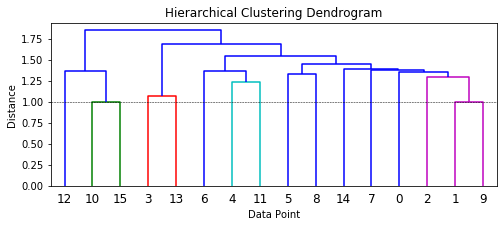

In [22]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [23]:
print(corpus_0_4[12])
print(corpus_0_4[10])

sorry say cant understand imdb rating
torment watch aot


In [24]:
from scipy.cluster.hierarchy import fcluster
max_dist=1.0
cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([pd.DataFrame(corpus_0_4, columns = ['document']), cluster_labels], axis=1)

,document,ClusterLabel
0,insanely boring,12
1,seriously,10
2,overhyped,11
3,actually great concept,3
4,like really every god episode looks like minut...,5
5,minutes non animated absolutely repetitive tho...,8
6,repeat exactly quotes,7
7,fight scenes,13
8,actually interesting watch sec whole mins mins...,9
9,,10


In [27]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=3, max_iter=1000, random_state=0)
dt_matrix = lda.fit_transform(cv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2', 'T3'])
features

,T1,T2,T3
0,0.776419,0.111737,0.111844
1,0.664474,0.167675,0.167851
2,0.168127,0.167786,0.664087
3,0.086434,0.829786,0.083779
4,0.026454,0.025997,0.947550
5,0.943229,0.028512,0.028259
6,0.084109,0.826031,0.089859
7,0.112171,0.775763,0.112066
8,0.037662,0.924314,0.038025
9,0.333333,0.333333,0.333333


In [30]:
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1]>0.6]
    print(topic)
    print()

[('actually', 1.3402287056933062), ('minutes', 1.333820486178929), ('absolutely', 1.3329700034743543), ('animated', 1.3329700034743543), ('emotional', 1.3329700034743543), ('flashbacks', 1.3329700034743543), ('important', 1.3329700034743543), ('non', 1.3329700034743543), ('repetitive', 1.3329700034743543), ('sh', 1.3329700034743543), ('thoughts', 1.3329700034743543), ('beings', 1.3329220827370398), ('get', 1.3329220827370398), ('human', 1.3329220827370398), ('idea', 1.3329220827370398), ('retarded', 1.3329220827370398), ('series', 1.3329220827370398), ('th', 1.3329220827370398), ('youll', 1.3329220827370398), ('written', 1.3316326467326238), ('boring', 1.3312962446163428), ('insanely', 1.3312962446163428), ('seriously', 1.328949228528045), ('episode', 1.3273726238305972)]

[('watch', 3.332327128451464), ('mins', 2.332639999198054), ('imdb', 2.332598003961875), ('rating', 2.332598003961875), ('aot', 2.3321348043345567), ('concept', 2.3316915046179), ('actually', 2.325648036672948), ('gi

## Bible corpus

In [10]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt')
remove_terms = punctuation + '0123456789'
norm_bible = [[word.lower() for word in sent if word not in  remove_terms] 
             for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split())>2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: and god said let there be a firmament in the midst of the waters and let it divide the waters from the waters


[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/murayasu/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [9]:
bible

[['[', 'The', 'King', 'James', 'Bible', ']'], ['The', 'Old', 'Testament', 'of', 'the', 'King', 'James', 'Bible'], ...]